# Custom CNN Model

# Import Necessary Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from keras.regularizers import l2
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import classification_report

# Building Helper Functions

In [2]:
'''
This function `create_dataframe_from_directory` takes two parameters `data_dir` and `label`. 
It reads files from the specified directory `data_dir`, assigns the given `label` to each file, 
and then creates a pandas DataFrame with two columns: 'filename' containing the file paths and 'label' containing the assigned labels.
'''

def create_dataframe_from_directory(data_dir, label):
    filenames = []
    labels = []
    if os.path.isdir(data_dir):
        for filename in os.listdir(data_dir):
            file_path = os.path.join(data_dir, filename)
            if os.path.isfile(file_path):
                filenames.append(file_path)
                labels.append(label)
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })

# Fetching the Data

In [3]:
base_path = '/Users/mahamedabdulle/Documents/BSc Computer Science/Year 3/Final Year Project/archive (1)/Lung Segmentation Data/Lung Segmentation Data/'

directories = ['Val', 'Test', 'Train']
categories = ['COVID-19', 'Non-COVID', 'Normal']

dataframes = {}

for directory in directories:
    for category in categories:
        folder_path = os.path.join(base_path, directory, category, 'images')
        data = create_dataframe_from_directory(folder_path, category)
        key = f"{category}_{directory}"
        dataframes[key] = data
        print(f"{category} Data length ({directory}): {len(data)}")
        print()

all_data = pd.concat(dataframes, ignore_index=True)
print(len(all_data))

COVID-19 Data length (Val): 1903

Non-COVID Data length (Val): 1802

Normal Data length (Val): 1712

COVID-19 Data length (Test): 2395

Non-COVID Data length (Test): 2253

Normal Data length (Test): 2140

COVID-19 Data length (Train): 7658

Non-COVID Data length (Train): 7208

Normal Data length (Train): 6849

33920


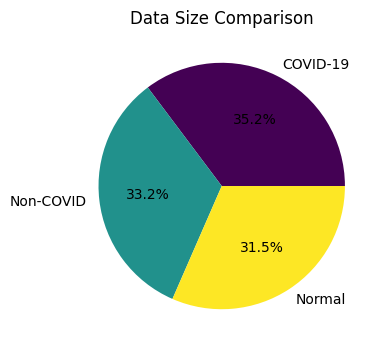

In [4]:
lengths = all_data['label'].value_counts()

cmap = plt.get_cmap('viridis')

# Generate a color range within the chosen cmap
# linspace generates a range of values from 0 to 1 for the color map
colors = cmap(np.linspace(0, 1, len(categories)))


plt.figure(figsize=(7, 4))
plt.pie(lengths, labels=categories, colors=colors, autopct='%1.1f%%')

# Add title and labels
plt.title('Data Size Comparison')

# Show the graph
plt.show()

In [5]:
all_data['label'].unique()

array(['COVID-19', 'Non-COVID', 'Normal'], dtype=object)

## Looking at the X-Rays

### COVID-19 X-Ray

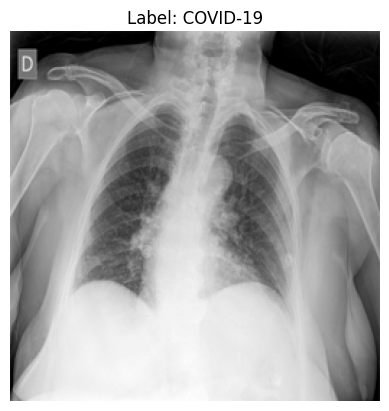

In [6]:
covid1 = all_data.iloc[0]
c1_image = Image.open(covid1['filename'])
c1_label = covid1['label']  # Get the actual label from the DataFrame

# Plot the image
plt.imshow(c1_image, cmap='gray')
plt.title(f"Label: {c1_label}")  # Use the label from the DataFrame
plt.axis('off')  # Hide the axis
plt.show()


### Normal X-Ray

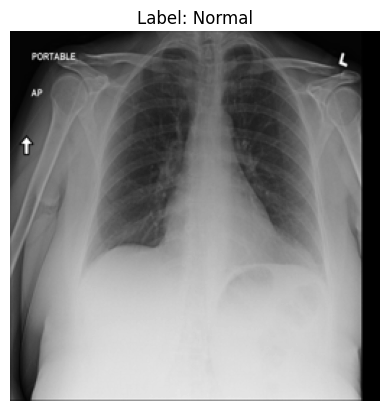

In [7]:
normal_instance = all_data.loc[all_data['label'] == 'Normal'].iloc[0]
n_image = Image.open(normal_instance['filename'])
n_label = normal_instance['label']

# Now plot the image
plt.imshow(n_image, cmap='gray')
plt.title(f"Label: {n_label}")
plt.axis('off')
plt.show()


### Non-COVID-19 X-Ray

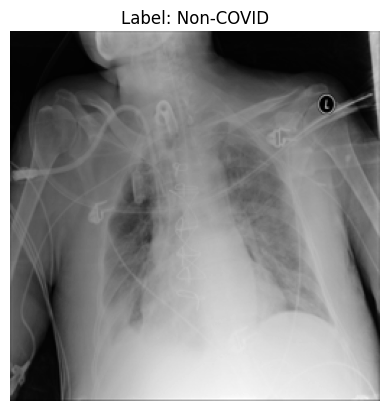

In [8]:
non_instance = all_data.loc[all_data['label'] == 'Non-COVID'].iloc[0]
non_image = Image.open(non_instance['filename'])
non_label = non_instance['label']

# Now plot the image
plt.imshow(non_image, cmap='gray')
plt.title(f"Label: {non_label}")
plt.axis('off')
plt.show()

### Getting the Data Ready

In [9]:
# Splitting the data into 70% training and 30% temporary (test + validation)
train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=42)

# Splitting the temporary data into 66.7% testing and 33.3% validation
# This results in 20% testing and 10% validation of the original data
test_data, val_data = train_test_split(temp_data, test_size=0.33, random_state=42)

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

image_height = 224
image_width = 224
batch_size = 64


train_generator = datagen.flow_from_dataframe(
    dataframe = train_data,
    x_col = 'filename',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (image_height,image_width),
    batch_size = batch_size,
    color_mode = 'rgb'
    )

test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    x_col = 'filename',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (image_height,image_width),
    batch_size = batch_size,
    color_mode = 'rgb',
    shuffle = False,
    )

validation_generator = datagen.flow_from_dataframe(
    dataframe = val_data,
    x_col = 'filename',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (image_height,image_width),
    batch_size = batch_size,
    color_mode = 'rgb'
    )



Found 23744 validated image filenames belonging to 3 classes.
Found 6817 validated image filenames belonging to 3 classes.
Found 3359 validated image filenames belonging to 3 classes.


In [11]:
## Looking at how data is split
# Count samples in each class for the training set
train_class_counts = train_data['label'].value_counts()
print("Training set counts per class:\n", train_class_counts)

# Count samples in each class for the validation set
validation_class_counts = val_data['label'].value_counts()
print("\nValidation set counts per class:\n", validation_class_counts)

# Count samples in each class for the test set
test_class_counts = test_data['label'].value_counts()
print("\nTest set counts per class:\n", test_class_counts)


Training set counts per class:
 label
COVID-19     8377
Non-COVID    7916
Normal       7451
Name: count, dtype: int64

Validation set counts per class:
 label
COVID-19     1189
Non-COVID    1092
Normal       1078
Name: count, dtype: int64

Test set counts per class:
 label
COVID-19     2390
Non-COVID    2255
Normal       2172
Name: count, dtype: int64


### Building the Model

In [15]:
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(image_height, image_width,3), 
           kernel_regularizer=l2(0.001)),  
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)), 
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.5), 
    Dense(64,activation='relu'),
    Dense(3, activation='softmax')  
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [16]:
# Evaluating the model on the test set before training
initial_test_loss, initial_test_accuracy = model.evaluate(test_generator)
print('Initial Test accuracy:', initial_test_accuracy)

107/107 [==============================] - 60s 547ms/step - loss: 1.4470 - accuracy: 0.3189
Initial Test accuracy: 0.31890860199928284


In [17]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Evaluating the model on the test set after training
final_test_loss, final_test_accuracy = model.evaluate(test_generator)


Epoch 1/10
371/371 [==============================] - 942s 3s/step - loss: 1.0594 - accuracy: 0.6378 - val_loss: 0.8625 - val_accuracy: 0.7374
Epoch 2/10
371/371 [==============================] - 995s 3s/step - loss: 0.8205 - accuracy: 0.7510 - val_loss: 0.7049 - val_accuracy: 0.8035
Epoch 3/10
371/371 [==============================] - 1199s 3s/step - loss: 0.7522 - accuracy: 0.7845 - val_loss: 0.7104 - val_accuracy: 0.8050
Epoch 4/10
371/371 [==============================] - 1003s 3s/step - loss: 0.7258 - accuracy: 0.7978 - val_loss: 0.6798 - val_accuracy: 0.8170
Epoch 5/10
371/371 [==============================] - 1028s 3s/step - loss: 0.6996 - accuracy: 0.8129 - val_loss: 0.6603 - val_accuracy: 0.8299
Epoch 6/10
371/371 [==============================] - 891s 2s/step - loss: 0.6902 - accuracy: 0.8194 - val_loss: 0.6706 - val_accuracy: 0.8272
Epoch 7/10
371/371 [==============================] - 858s 2s/step - loss: 0.6766 - accuracy: 0.8286 - val_loss: 0.6938 - val_accuracy: 0.8

In [18]:
print('Final Test accuracy:', final_test_accuracy)

Final Test accuracy: 0.8402523398399353


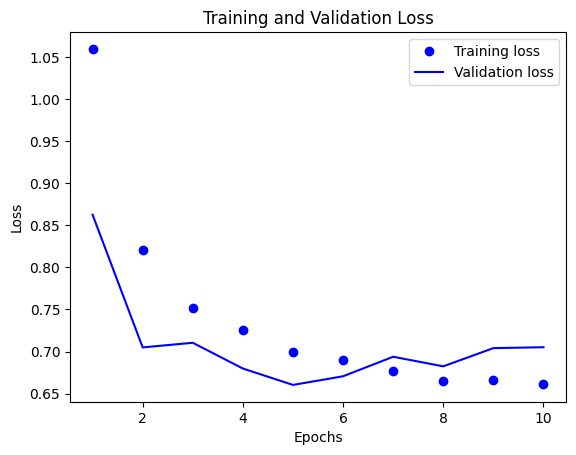

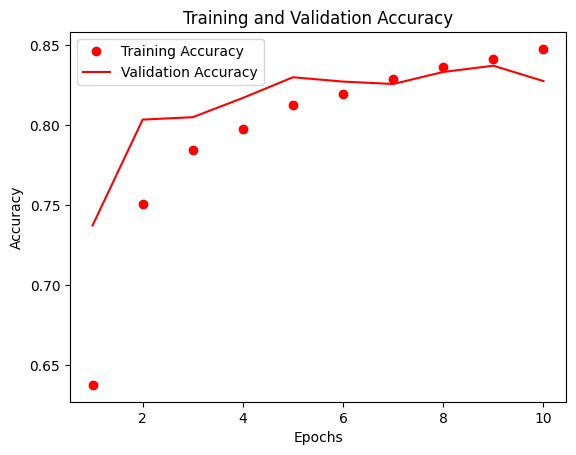

In [19]:
# Extracting data from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure()
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


if 'accuracy' in history.history:
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    plt.figure()
    plt.plot(epochs, training_accuracy, 'ro', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()

In [20]:
# 1. Generate Predictions
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size)

# 2. Convert Predictions to Class Labels
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the length of true_classes matches that of predicted_classes
# This is important as the generator could loop indefinitely
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

# 3. Calculate F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"F1-Score: {f1}")

recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall: {recall}")

106/106 [==============================] - 60s 566ms/step
F1-Score: 0.839248550533472
Recall: 0.8374583700309547


In [21]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

    COVID-19       0.90      0.94      0.92      2378
   Non-COVID       0.80      0.80      0.80      2248
      Normal       0.82      0.77      0.79      2158

    accuracy                           0.84      6784
   macro avg       0.84      0.84      0.84      6784
weighted avg       0.84      0.84      0.84      6784

